# Date: 9 2022
# Method: Cross_Inception
# Data: Pavia
# Results v.05

In [118]:
# Libraries
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.decomposition import PCA


In [119]:
# Read dataset Pavia
from scipy.io import loadmat

def read_HSI():
  X = loadmat('PaviaU.mat')['paviaU']
  y = loadmat('PaviaU_gt.mat')['paviaU_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (610, 340, 103)
y shape: (610, 340)


In [120]:
# PCA
def applyPCA(X, numComponents): # numComponents=64
    newX = np.reshape(X, (-1, X.shape[2]))
    print(newX.shape)
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca, pca.explained_variance_ratio_

In [121]:
# channel_wise_shift
def channel_wise_shift(X,numComponents):
    X_copy = np.zeros((X.shape[0] , X.shape[1], X.shape[2]))
    half = int(numComponents/2)
    for i in range(0,half-1):
        X_copy[:,:,i] = X[:,:,(half-i)*2-1]
    for i in range(half,numComponents):
        X_copy[:,:,i] = X[:,:,(i-half)*2]
    X = X_copy
    return X

In [122]:
# Split the hyperspectral image into patches of size windowSize-by-windowSize pixels
def Patches_Creating(X, y, windowSize, removeZeroLabels = True):  # windowSize=15, 25
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]),dtype="float16")
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]),dtype="float16")
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
# pading With Zeros
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]),dtype="float16")
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [123]:
# Split Data
from sklearn.model_selection import train_test_split

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,stratify=y)
    return X_train, X_test, y_train, y_test

In [124]:
test_ratio = 0.5

# Load and reshape data for training
X0, y0 = read_HSI()
#X=X0
#y=y0

windowSize=55
width = windowSize
height = windowSize
img_width, img_height, img_num_channels = windowSize, windowSize, 3

input_image_size=windowSize
INPUT_IMG_SIZE=windowSize

dimReduction=3

InputShape=(windowSize, windowSize, dimReduction)

#X, y = loadData(dataset) channel_wise_shift
X1,pca,ratio = applyPCA(X0,numComponents=dimReduction)
X2_shifted = channel_wise_shift(X1,dimReduction) # channel-wise shift
#X2=X1

#print(f"X0 shape: {X0.shape}\ny0 shape: {y0.shape}")
#print(f"X1 shape: {X1.shape}\nX2 shape: {X2.shape}")

X3, y3 = Patches_Creating(X2_shifted, y0, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X3, y3, test_ratio)


X shape: (610, 340, 103)
y shape: (610, 340)
(207400, 103)


In [125]:
# Compile the model
#incept_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [126]:
print()

import warnings
warnings.filterwarnings("ignore")

# load libraries
from keras.initializers import VarianceScaling
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Dense
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
import numpy as np



In [127]:
# 9 classes names
names = ['1. Asphalt', '2. Meadows', '3. Gravel', '4. Trees', 
                 '5. Painted metal sheets','6. Bare Soil', '7. Bitumen', 
                 '8. Self-Blocking Bricks', '9. Shadows']

In [128]:
from tensorflow.keras.applications import EfficientNetB0
from keras.applications import densenet, inception_v3, mobilenet, resnet, vgg16, vgg19, xception

#model = EfficientNetB0(weights='imagenet')


def build_model(num_classes):
    inputs = layers.Input(shape=(windowSize, windowSize, 3))
    #x = img_augmentation(inputs)
    model = xception.Xception(weights='imagenet', include_top=False, input_tensor=inputs)

    #model1 = resnet.ResNet50(weights='imagenet')


    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    #x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    #x = layers.BatchNormalization()(x)

    x = model.output


    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    

    top_dropout_rate = 0.2
    #x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(9, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [129]:
model = build_model(num_classes=9)


In [130]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [131]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
100/100 - 20s - loss: 1.0531 - accuracy: 0.7059 - val_loss: 0.6893 - val_accuracy: 0.7725 - 20s/epoch - 196ms/step
Epoch 2/20
100/100 - 18s - loss: 0.4913 - accuracy: 0.8438 - val_loss: 0.3458 - val_accuracy: 0.8938 - 18s/epoch - 180ms/step
Epoch 3/20
100/100 - 18s - loss: 0.3568 - accuracy: 0.8881 - val_loss: 0.5468 - val_accuracy: 0.8550 - 18s/epoch - 179ms/step
Epoch 4/20
100/100 - 18s - loss: 0.2688 - accuracy: 0.9125 - val_loss: 0.2411 - val_accuracy: 0.9287 - 18s/epoch - 180ms/step
Epoch 5/20
100/100 - 18s - loss: 0.2440 - accuracy: 0.9303 - val_loss: 0.1907 - val_accuracy: 0.9362 - 18s/epoch - 178ms/step
Epoch 6/20
100/100 - 19s - loss: 0.2053 - accuracy: 0.9353 - val_loss: 0.2054 - val_accuracy: 0.9287 - 19s/epoch - 193ms/step
Epoch 7/20
100/100 - 18s - loss: 0.1639 - accuracy: 0.9538 - val_loss: 0.3043 - val_accuracy: 0.9075 - 18s/epoch - 175ms/step
Epoch 8/20
100/100 - 

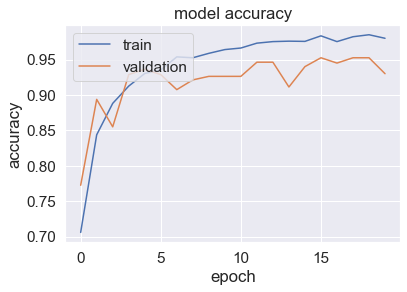

Score for fold 1: loss of 0.3018658757209778; accuracy of 93.00000071525574%
25/25 [==============================] - 4s 150ms/step
[[ 98   0   1  11   0   1   0   0   0]
 [  0 347   2   2   0   0   0   0   1]
 [  0   0  39   1   0   0   0   0   0]
 [  4   3   3  48   0   0   0   0   0]
 [  0   0   0   0  24   0   0   0   0]
 [  0   0   0   0   0  86   0   0   0]
 [  1   0   2   0   0   0  30   0   0]
 [  8   0   2   6   0   0   0  65   0]
 [  0   0   2   2   1   0   3   0   7]]
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/20
100/100 - 20s - loss: 1.0306 - accuracy: 0.7103 - val_loss: 0.6047 - val_accuracy: 0.7975 - 20s/epoch - 200ms/step
Epoch 2/20
100/100 - 17s - loss: 0.5139 - accuracy: 0.8391 - val_loss: 0.3733 - val_accuracy: 0.8863 - 17s/epoch - 172ms/step
Epoch 3/20
100/100 - 17s - loss: 0.3385 - accuracy: 0.8928 - val_loss: 0.3153 - val_accuracy: 0.9013 - 17s/epoch - 172ms/step
Epoch 4/20
100/100 - 17s - loss: 0.2852 -

<Figure size 432x288 with 0 Axes>

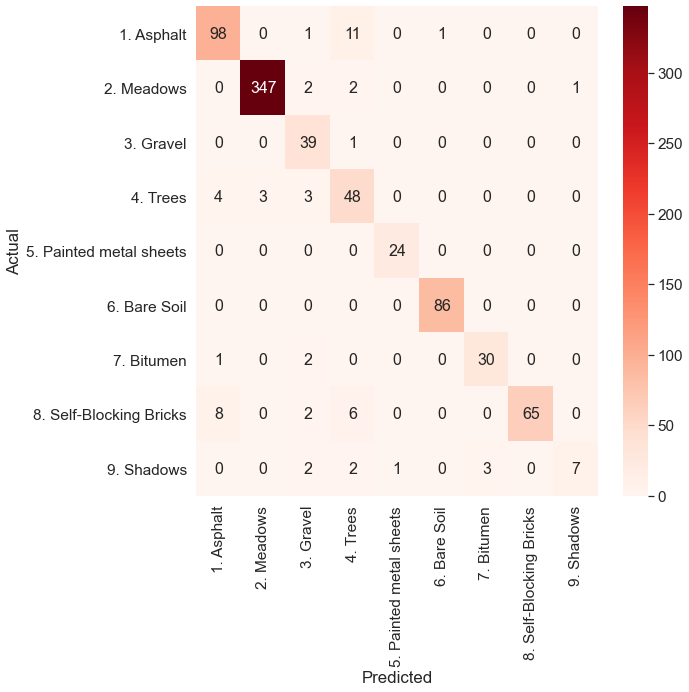

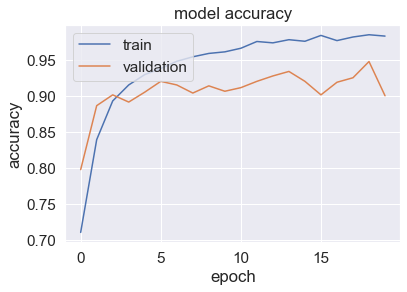

Score for fold 2: loss of 0.5535435676574707; accuracy of 89.99999761581421%
25/25 [==============================] - 4s 146ms/step
[[ 98   0   1   0   0   0   0   0   0]
 [ 11 352   0   0   0   1   0   0   0]
 [  4   0  27   0   0   0   0   0   0]
 [ 32   4   2  34   0   0   0   2   1]
 [  0   0   0   0  26   0   0   0   0]
 [  2   1   0   0   0  96   0   0   0]
 [  2   0   0   0   0   0  22   0   0]
 [  4   1   0   2   0   0   0  60   0]
 [  3   0   2   0   2   0   3   0   5]]
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/20
100/100 - 20s - loss: 1.0540 - accuracy: 0.7125 - val_loss: 0.6653 - val_accuracy: 0.7775 - 20s/epoch - 196ms/step
Epoch 2/20
100/100 - 17s - loss: 0.4957 - accuracy: 0.8431 - val_loss: 0.4522 - val_accuracy: 0.8500 - 17s/epoch - 172ms/step
Epoch 3/20
100/100 - 19s - loss: 0.3508 - accuracy: 0.8863 - val_loss: 0.3886 - val_accuracy: 0.8925 - 19s/epoch - 188ms/step
Epoch 4/20
100/100 - 17s - loss: 0.2722 -

<Figure size 432x288 with 0 Axes>

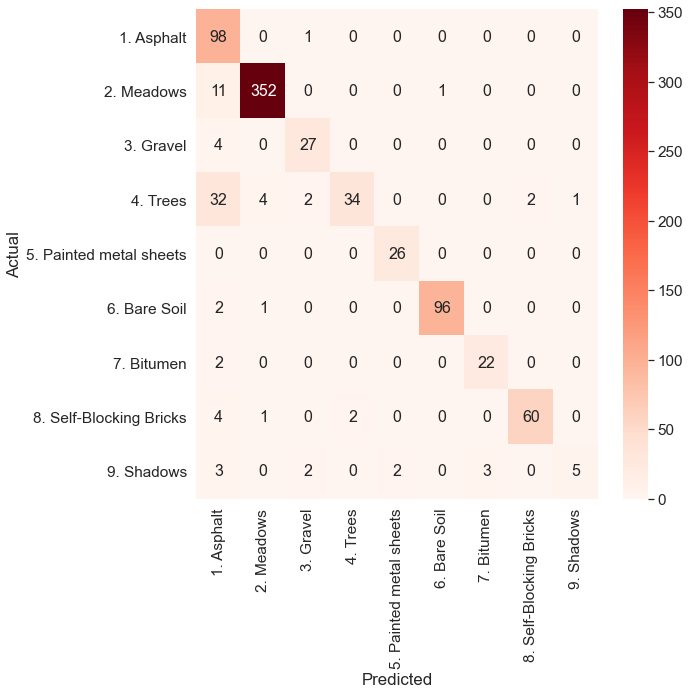

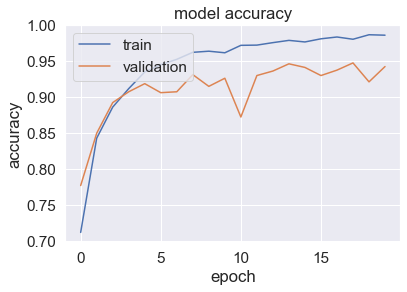

Score for fold 3: loss of 0.2766573429107666; accuracy of 94.24999952316284%
25/25 [==============================] - 4s 149ms/step
[[115   5   0   2   0   0   0   2   1]
 [  1 353   0   1   0   0   0   1   0]
 [  1   0  30   0   0   1   0   0   3]
 [ 13   3   0  45   0   0   0   2   0]
 [  0   0   0   0  27   0   0   0   1]
 [  1   0   0   0   0  79   0   0   1]
 [  0   0   1   0   0   0  22   0   0]
 [  3   0   0   1   0   0   0  70   0]
 [  0   0   0   0   2   0   0   0  13]]
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/20
100/100 - 19s - loss: 1.0672 - accuracy: 0.7100 - val_loss: 0.6143 - val_accuracy: 0.8125 - 19s/epoch - 193ms/step
Epoch 2/20
100/100 - 17s - loss: 0.5204 - accuracy: 0.8469 - val_loss: 0.3869 - val_accuracy: 0.8687 - 17s/epoch - 173ms/step
Epoch 3/20
100/100 - 19s - loss: 0.3590 - accuracy: 0.8934 - val_loss: 0.4307 - val_accuracy: 0.8813 - 19s/epoch - 188ms/step
Epoch 4/20
100/100 - 17s - loss: 0.2688 -

<Figure size 432x288 with 0 Axes>

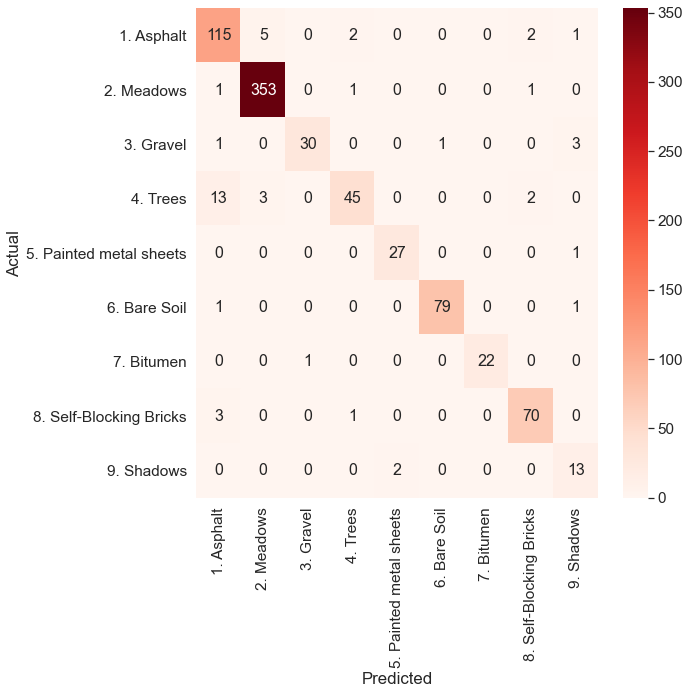

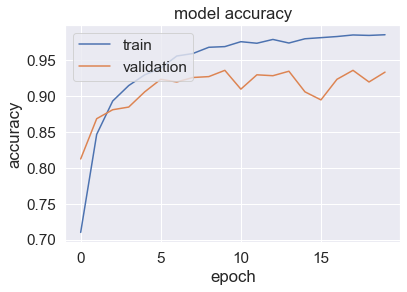

Score for fold 4: loss of 0.3463292717933655; accuracy of 93.37499737739563%
25/25 [==============================] - 4s 156ms/step
[[101   1   1  11   0   0   0   5   1]
 [  2 343   0   1   0   0   0   0   0]
 [  0   0  38   0   0   0   0   0   1]
 [  5   5   0  49   0   0   0   4   1]
 [  0   0   0   0  21   0   0   0   1]
 [  0   2   0   0   0  96   1   0   0]
 [  0   0   0   0   0   0  23   0   1]
 [  1   2   1   0   0   0   0  63   0]
 [  0   0   0   1   3   0   1   1  13]]
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/20
100/100 - 22s - loss: 1.0179 - accuracy: 0.7147 - val_loss: 0.5308 - val_accuracy: 0.8375 - 22s/epoch - 216ms/step
Epoch 2/20
100/100 - 17s - loss: 0.5096 - accuracy: 0.8431 - val_loss: 0.4650 - val_accuracy: 0.8512 - 17s/epoch - 174ms/step
Epoch 3/20
100/100 - 17s - loss: 0.3603 - accuracy: 0.8863 - val_loss: 0.4769 - val_accuracy: 0.8562 - 17s/epoch - 174ms/step
Epoch 4/20
100/100 - 17s - loss: 0.3076 -

<Figure size 432x288 with 0 Axes>

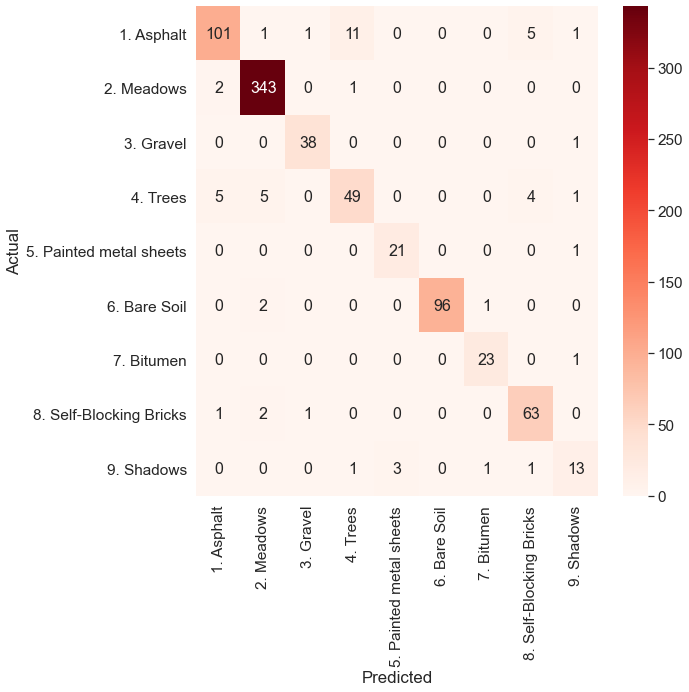

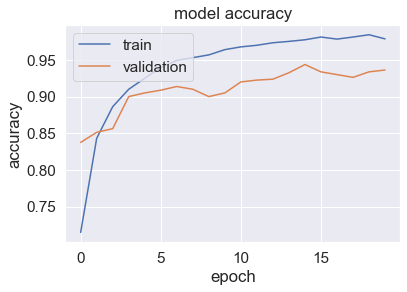

Score for fold 5: loss of 0.25994670391082764; accuracy of 93.62499713897705%
25/25 [==============================] - 4s 150ms/step
[[116   0   2   7   0   0   0   2   0]
 [  1 321   0   3   0   0   0   0   0]
 [  1   2  35   0   0   0   0   0   3]
 [ 11   1   0  39   0   0   0   2   0]
 [  0   0   0   0  22   0   0   0   7]
 [  0   2   0   0   0 101   0   0   0]
 [  0   0   0   0   0   0  29   0   2]
 [  0   1   1   0   0   0   0  71   0]
 [  0   1   1   0   0   1   0   0  15]]
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.3018658757209778 - Accuracy: 93.00000071525574%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5535435676574707 - Accuracy: 89.99999761581421%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.2766573429107666 - Accuracy: 94.24999952316284%
-------

<Figure size 432x288 with 0 Axes>

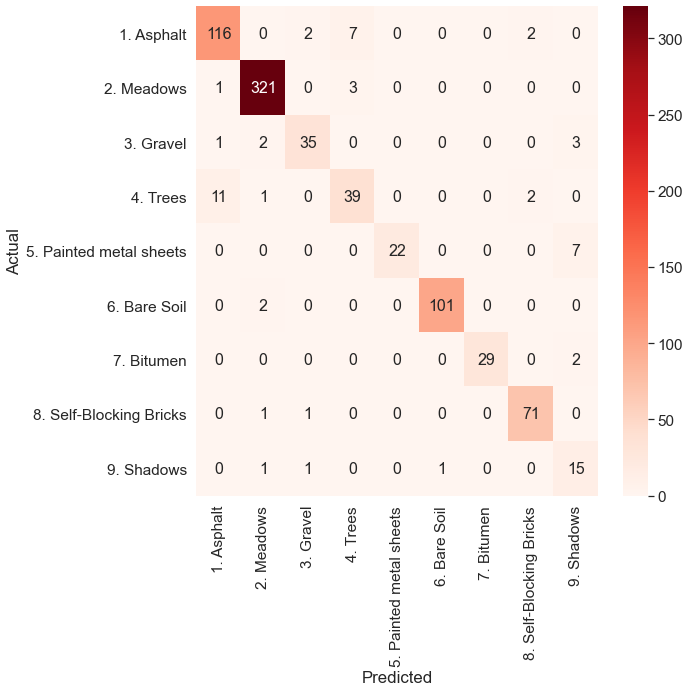

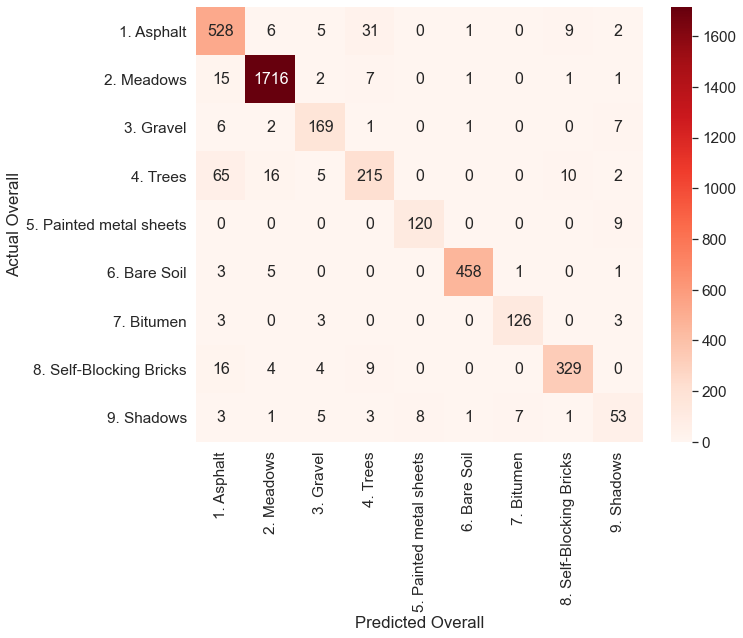

In [132]:

from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras import layers

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model

import tensorflow as tf

# configuration
confmat = 0
batch_size = 50
loss_function = sparse_categorical_crossentropy
no_classes = 9
no_epochs = 20
optimizer = Adam()
verbosity = 1
num_folds = 5

NN=len(Xtrain)
NN=2000

input_train=Xtrain[0:NN]
target_train=ytrain[0:NN]

input_test=Xtest[0:NN]
target_test=ytest[0:NN]

# Determine shape of the data
input_shape = (img_width, img_height, img_num_channels)

# Parse numbers as floats
#input_train = input_train.astype('float32')
#input_test = input_test.astype('float32')

# Normalize data
#input_train = input_train / 255
#input_test = input_test / 255

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

Y_pred=[]
y_pred=[]
# Merge inputs and targets
inputs = np.concatenate((input_train, input_test), axis=0)
targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  #  model architecture

  # Compile the model
  #model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

   # Compile the model
 # model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

  model = build_model(num_classes=9)
  #model.compile(loss=loss_function, optimizer='rmsprop',metrics=['accuracy'])

  #model.summary()

  #unfreeze_model(model)
  model.compile(loss=loss_function, optimizer='rmsprop',metrics=['accuracy'])



  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  #model.summary()
  
  history = model.fit(inputs[train], targets[train],
              validation_data = (inputs[test],targets[test]),
              epochs=no_epochs,verbose=2 )
  plt.figure()
  plot_hist(history)
 # hist = model.fit(inputs[train], targets[train],
   #                 steps_per_epoch=(29943/batch_size),
   #                 epochs=5,
   #                 validation_data=(inputs[test],targets[test]),
   #                 validation_steps=(8000/batch_size),
   #                 initial_epoch=20,
   #                 verbose=1 )
  plt.figure()
    


  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test],verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # confusion_matrix
  Y_pred = model.predict(inputs[test])
  y_pred = np.argmax(Y_pred, axis=1)
  #target_test=targets[test]

  confusion = confusion_matrix(targets[test], y_pred)
  df_cm = pd.DataFrame(confusion, columns=np.unique(names), index = np.unique(names))
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (9,9))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
  plt.savefig('cmap.png', dpi=300)
  print(confusion_matrix(targets[test], y_pred))

  confmat    = confmat + confusion; 
  

  # Increase fold number
  fold_no = fold_no + 1

# == average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Overall_Conf = pd.DataFrame(confmat, columns=np.unique(names), index = np.unique(names))
Overall_Conf.index.name = 'Actual Overall'
Overall_Conf.columns.name = 'Predicted Overall'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(Overall_Conf, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)
print(Overall_Conf)
